In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
from FSC import GenerationDiscreteObs as FSC_DiscreteObs
from FSC import InferenceDiscreteObs as FSC_InferenceDiscreteObs
import ObsModels 

In [89]:
# set matplotlib font to avenir
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

# Finite State Controller with $M = 2$, $A = 2$, $Y = 2$

# Observations, one step

In [90]:
NStepsObs = 1
NTraj = 500
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)
observations.shape

(500, 1)

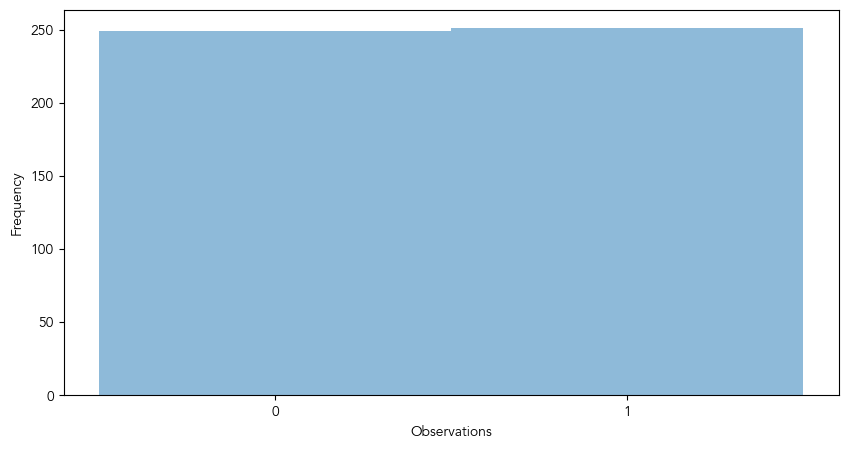

In [91]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.hist(observations.flatten(), bins = np.arange(-0.5, Y+0.5, 1), alpha = 0.5)

ax.set_xlabel('Observations')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, Y, 1))

plt.show()

In [92]:
M = 2
A = 2

np.random.seed(0)
Theta = np.random.randn(Y, M, M, A)
Psi = np.array([1, 2])

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [93]:
FSC.load_observations(observations)

In [94]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

In [95]:
trajectories[0]

{'actions': array([0], dtype=int32),
 'memories': array([1], dtype=int32),
 'observations': array([0], dtype=int32)}

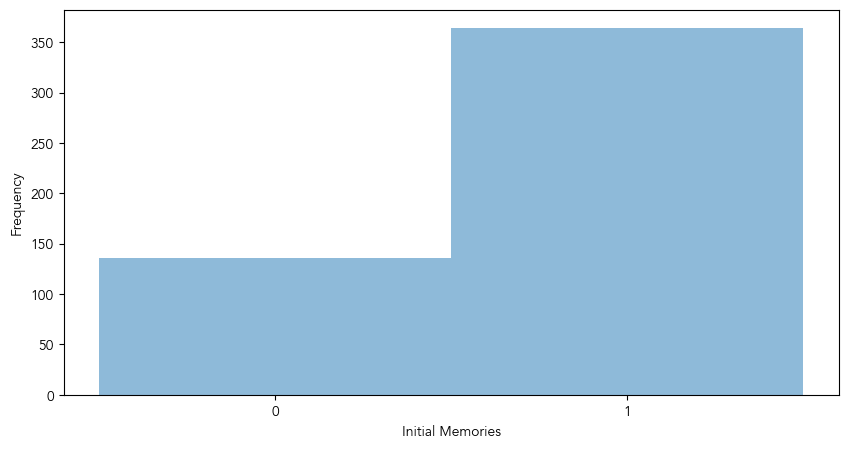

In [96]:
initial_memories = np.array([tr["memories"][0] for tr in trajectories])

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.hist(initial_memories.flatten(), bins = np.arange(-0.5, M+0.5, 1), alpha = 0.5)

ax.set_xlabel('Initial Memories')
ax.set_ylabel('Frequency')

ax.set_xticks(np.arange(0, M, 1))

plt.show()

In [97]:
FSC.evaluate_nloglikelihood(trajectories[0])

0.27293489590930026

### Inference

In [98]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(0.6199, device='mps:0', grad_fn=<SubBackward0>)

In [99]:
tloss, vloss = FSC_tofit.optimize_psionly(NEpochs = 20, NBatch = 100, lr = 0.1, gamma = 0.9)

Training with 400 trajectories and validating with 100 trajectories.
	 Epoch 1 - Batch 1 - Loss: 0.67438232421875 - Learning rate: 0.1
	 Epoch 1 - Batch 2 - Loss: 0.7064846801757813 - Learning rate: 0.1
	 Epoch 1 - Batch 3 - Loss: 0.6810441589355469 - Learning rate: 0.1
	 Epoch 1 - Batch 4 - Loss: 0.6582538604736328 - Learning rate: 0.1
Epoch 1 - Training loss: 0.6800412559509277, Validation loss: 0.660645272731781
	 Epoch 2 - Batch 1 - Loss: 0.6058165359497071 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 2 - Loss: 0.6228842163085937 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 3 - Loss: 0.6982341003417969 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 4 - Loss: 0.6325959777832031 - Learning rate: 0.09000000000000001
Epoch 2 - Training loss: 0.6398827075958252, Validation loss: 0.608472638130188
	 Epoch 3 - Batch 1 - Loss: 0.6053871154785156 - Learning rate: 0.08100000000000002
	 Epoch 3 - Batch 2 - Loss: 0.6288030242919922 - Learning rate: 0.081000000000000

### Comparison

In [100]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


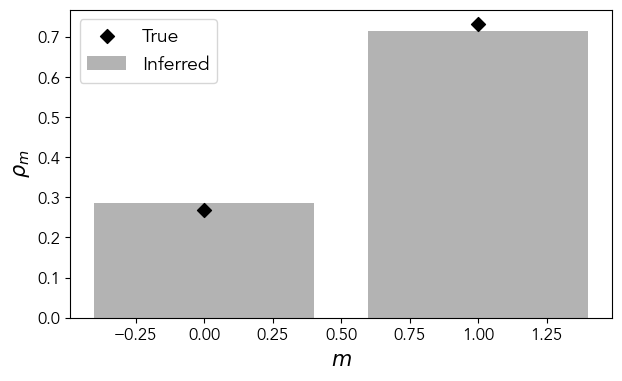

In [101]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14)

plt.show()

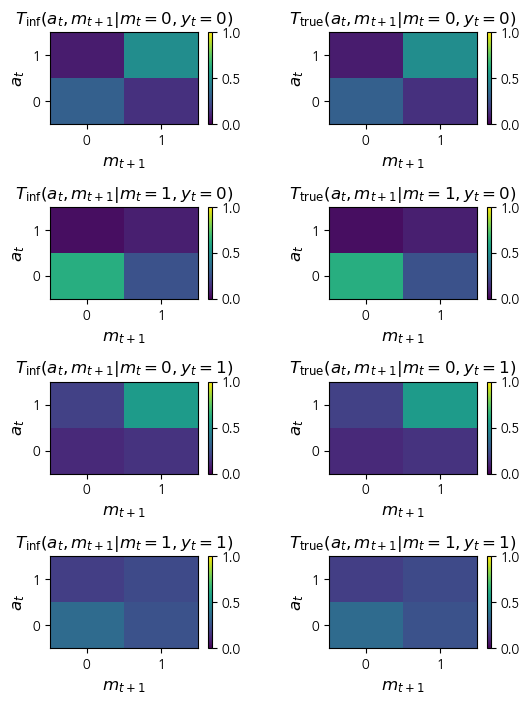

In [53]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,8))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()